In [13]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import PCA

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Create data frame of annotation info

In [19]:
features_path = 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/annot_features_full.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.dropna(axis = 0, inplace=True)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.head()

(1084, 7)
Int64Index([742], dtype='int64')
(1083, 7)
Int64Index([], dtype='int64')


,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur
0,0,533,5,low slug,46305.0,32714.904,0.368722
1,1,533,5,low slug,149692.5,43037.465,0.306856
2,2,533,5,low slug,243157.5,270193.530,0.062226
3,3,533,5,low slug,243270.0,63014.450,0.232295
4,4,533,5,low multi,295560.0,74933.164,0.206291


In [4]:
annot_labels = annot_features_full['Annotation']
print(annot_labels.values)
annot_labels.replace(regex={r'low slug': 1, 'high slug': 1, 'low multi': 1, 'high multi': 1, 'bbc': 1, 'noise': 0, 'rand_noise': 0}, inplace=True)
annot_labels.tail()

['low slug' 'low slug' 'low slug' ... 'rand_noise' 'rand_noise'
 'rand_noise']


1079    0
1080    0
1081    0
1082    0
1083    0
Name: Annotation, dtype: int64

In [5]:
annot_features = annot_features_full[['power_sum', 'spec_pur']]
annot_features.head()

,power_sum,spec_pur
0,32714.904,0.368722
1,43037.465,0.306856
2,270193.530,0.062226
3,63014.450,0.232295
4,74933.164,0.206291


In [30]:
# center and scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(annot_features)

#Scaled
X_train, X_test, y_train, y_test = train_test_split(features_scaled, annot_labels, test_size=0.3,random_state=1)

In [31]:
from sklearn.dummy import DummyClassifier
dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y_train)
y_dumb_class = dumb_model.predict(X_test)
print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(y_test, y_dumb_class))

Most frequent class dummy classifier test accuracy:  0.8861538461538462


In [42]:
skf = StratifiedKFold(n_splits=5)
lr_cv = LogisticRegressionCV(random_state=0, cv = skf)

lr_cv.fit(features_scaled, annot_labels)

print("Test set accuracy of LR model: ",lr_cv.score(features_scaled, annot_labels))

Test set accuracy of LR model:  0.8993536472760849


2
[0.9019813669832458]
3
[0.9019813669832458, 0.6265715890973764]
4
[0.9019813669832458, 0.6265715890973764, 0.5990679097307096]
5
[0.9019813669832458, 0.6265715890973764, 0.5990679097307096, 0.598974005461357]
6
[0.9019813669832458, 0.6265715890973764, 0.5990679097307096, 0.598974005461357, 0.5448158630629907]
7
[0.9019813669832458, 0.6265715890973764, 0.5990679097307096, 0.598974005461357, 0.5448158630629907, 0.5449768858696844]
8
[0.9019813669832458, 0.6265715890973764, 0.5990679097307096, 0.598974005461357, 0.5448158630629907, 0.5449768858696844, 0.525744727613238]
9
[0.9019813669832458, 0.6265715890973764, 0.5990679097307096, 0.598974005461357, 0.5448158630629907, 0.5449768858696844, 0.525744727613238, 0.5247938531706215]


Text(0, 0.5, 'Silhouette Coefficient')

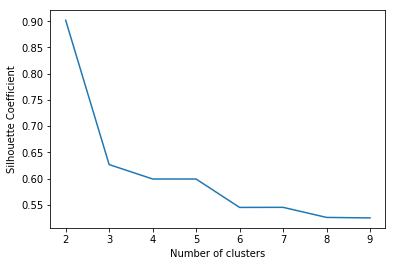

In [41]:
k_range = range(2,10)
scores = []
for k in k_range:
    print(k)
    km_ss = KMeans(n_clusters=k, random_state=19)
    km_ss.fit(features_scaled)
    scores.append(silhouette_score(features_scaled, km_ss.labels_))
    print(scores)

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [39]:
km2 = KMeans(n_clusters=2,random_state=19)
km2.fit(features_scaled)
score = silhouette_score(features_scaled, km_ss.labels_)
annot_features_full['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
#summary_ave.groupby('kmeans_2_scaled').mean()
print(score)

0.5244684689859119


In [40]:
annot_features_full.groupby('Annotation')['kmeans_2_scaled'].value_counts()

Annotation  kmeans_2_scaled
bbc         cluster_0           16
high multi  cluster_0            5
high slug   cluster_0            9
low multi   cluster_0           17
low slug    cluster_0           62
noise       cluster_0           71
            cluster_1            4
rand_noise  cluster_0          896
            cluster_1            3
Name: kmeans_2_scaled, dtype: int64